# Does sinusoidal feature encoding help with learning to flock?

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import sys
import os
script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/")
sys.path.append("/workspace/collab-environment/collab_env")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")

In [25]:
from collab_env.data.file_utils import expand_path, get_project_root
from collab_env.gnn.gnn import train_rules_gnn, debug_result2prediction, load_model
from collab_env.gnn.gnn_definition import GNN, GNN_residual
from collab_env.gnn.utility import dataset2testloader
from collab_env.sim.boids_gnn_temp.animal_simulation import  static_visualize_2sets
from collab_env.gnn.plotting_utility import load_various_data, load_rollout

import matplotlib.pyplot as plt
from rich import print
import seaborn as sns
import pandas as pd
import torch
import numpy as np
from tqdm.notebook import tqdm
from typing import List, Tuple
from pathlib import Path
from loguru import logger
import pickle
%matplotlib inline

## Section 1. Examples. 

### 1. Dataset

In [26]:
data_names = ["boid_single_species_basic", 'boid_food_basic'] #'runpod/boid_single_species_basic']

# set short versions of dataset names
data_names_short = {}
data_names_short['boid_single_species_independent'] = 'idpnt'
data_names_short['boid_single_species_basic'] = 'boid'
data_names_short['boid_food_basic'] = 'foodbasic'
data_names_short['boid_food_independent'] = 'foodidpnt'
data_names_short['boid_food_strong'] = 'foodstrong'

In [27]:
datasets = load_various_data(data_names, 1, return_dict = True)

### 2. Models

In [75]:
all_combinations = [
    ('boid_single_species_basic', 'vpluspplus_a', 0.005, 1, 0.5, 2, 1),
    ('boid_single_species_basic', 'vpluspplus_a', 0.005, 1, 0.5, 2, 2),
    ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 2, 1),
    ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 2, 2),
    ('boid_food_independent', 'vpluspplus_a', 0.005, 3, 0.5, 4, 2),
    #('boid_single_species_basic', 'sin', 0, 1, 0.5, 1, 1),
    #('boid_single_species_basic', 'sin', 0, 1, 0.5, 1, 2),
    #('boid_single_species_basic', 'sin', 0.005, 1, 0.5, 0, 2),
    #('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 2, ablation),
    #('boid_food_basic', 'sin', 0.005, 3, 0.5, 2, ablation)
]

### 3. Load rollout

In [77]:
rollout_results =  {}
data = {}
model_names = {}

for ind in range(len(all_combinations)):

    data_name, model_name, n, h, vr, s, attribution_type = all_combinations[ind]

    #if ablation:
    #    old_format = True
    #else:
    old_format = True
    spec = {
        "data_name": data_name,
        "head": h,
        "visual_range": vr,
        "seed": s,
        "rollout_starting_frame": 5,
        "noise": n,
        "seed": s,
        "old_format": old_format,
        "ablate": False
    }
    
    data_name_short = data_names_short[data_name]
    model_save_name = f'{model_name}\n{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}'

    
    #try:
        
    rollout_results[ind] = load_rollout(
            model_name, **spec)
    model_names[ind] = model_save_name
    print(f"{ind}, Successfully import {model_save_name}")
    #except:
    #    print(f"Cannot import {model_save_name}")

/workspace/collab-environment/trained_models/runpod/boid_single_species_basic/rollouts/boid_single_species_basic_vpluspplus_a_n0.005_h1_vr0.5_s2_rollout5.pkl


0, Successfully import vpluspplus_a
boid_
n0.005_h1_vr0.5_s2

/workspace/collab-environment/trained_models/runpod/boid_single_species_basic/rollouts/boid_single_species_basic_vpluspplus_a_n0.005_h1_vr0.5_s2_rollout5.pkl


1, Successfully import vpluspplus_a
boid_
n0.005_h1_vr0.5_s2

/workspace/collab-environment/trained_models/runpod/boid_food_basic/rollouts/boid_food_basic_vpluspplus_a_n0.005_h3_vr0.5_s2_rollout5.pkl


2, Successfully import vpluspplus_a
foodbasic_
n0.005_h3_vr0.5_s2

/workspace/collab-environment/trained_models/runpod/boid_food_basic/rollouts/boid_food_basic_vpluspplus_a_n0.005_h3_vr0.5_s2_rollout5.pkl


3, Successfully import vpluspplus_a
foodbasic_
n0.005_h3_vr0.5_s2

/workspace/collab-environment/trained_models/runpod/boid_food_independent/rollouts/boid_food_independent_vpluspplus_a_n0.005_h3_vr0.5_s4_rollout5.pkl


4, Successfully import vpluspplus_a
foodidpnt_
n0.005_h3_vr0.5_s4

### 4. Pick file etc

In [16]:
rollout_num = 50
file_id = 3 #13, 9, 10, 13, 260, 278, 263
starting_frame = 0
rollout_starting_frame = 5 - 3 #rollout result start to tally at frame 3
ending_frame = rollout_starting_frame + rollout_num

In [76]:
%matplotlib inline

model = 4
actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                    rollout_results[model],
                    file_id = file_id, epoch_num = 0)


ax = static_visualize_2sets(actual_pos[0], actual_vel[0], gnn_pos[0], gnn_vel[0],
                starting_frame = starting_frame, rollout_starting_frame = rollout_starting_frame, 
                ending_frame = ending_frame)

ax.set_title(f'Normal attention \n file {file_id} \n {model_names[model]}')
plt.show()

KeyError: 4

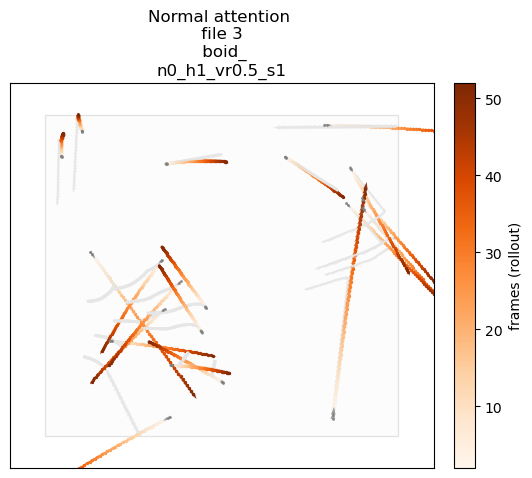

In [17]:
%matplotlib inline

model = 1
actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                    rollout_results[model],
                    file_id = file_id, epoch_num = 0)


ax = static_visualize_2sets(actual_pos[0], actual_vel[0], gnn_pos[0], gnn_vel[0],
                starting_frame = starting_frame, rollout_starting_frame = rollout_starting_frame, 
                ending_frame = ending_frame)

ax.set_title(f'Normal attention \n file {file_id} \n {model_names[model]}')
plt.show()

## Section 2: Load pretrained models and plot feature attribution

In [30]:
def return_mean_sd_attr(attr):
    epoch = 0
    
    attr_all = []
    for file_id in attr[epoch]:
        for f in range(len(attr[epoch][file_id])):
            attr_all.append(attr[epoch][file_id][f].reshape((1,-1)))
    
    attr_all_stack = torch.vstack(attr_all)

    attr_all_mean = torch.mean(attr_all_stack, 0)
    attr_all_std = torch.std(attr_all_stack, 0)

    return attr_all_mean, attr_all_std

In [31]:
all_combinations = [
    ('boid_single_species_basic', 'vpluspplus_a', 0, 1, 0.5, 2, 1),
    ('boid_single_species_basic', 'vpluspplus_a', 0, 1, 0.5, 2, 2),
    ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 2, 1),
    ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 2, 2)]

In [22]:
"""
all_combinations = [
    #('boid_single_species_basic', 'vpluspplus_a', 0, 1, 0.5, 2, 1),
    ('boid_single_species_basic', 'sin', 0, 1, 0.5, 1, 1),
    #('boid_single_species_basic', 'sin', 0, 1, 0.5, 1, 2),
    #('boid_single_species_basic', 'sin', 0.005, 1, 0.5, 0, 2),
    #('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 2, ablation),
    #('boid_food_basic', 'sin', 0.005, 3, 0.5, 2, ablation)
]
"""

### Pick a model

In [78]:
model_ind = 4

In [79]:
data_name, model_name, n, h, vr, s, attr = all_combinations[model_ind]

### Load attribute data

In [80]:
file_name = (
    f"{data_name}_{model_name}_n{n}_h{h}_vr{vr}_s{s}_rollout5"
)

folder = f"trained_models/runpod/{data_name}/rollouts"


attr_path = expand_path(
        f"{folder}/{file_name}_attribute{attr}.pkl",
        get_project_root())
    
with open(attr_path, 'rb') as file:
    attr = pickle.load(file)

attr_all_mean, attr_all_std = return_mean_sd_attr(attr)

In [81]:
if "sin" not in model_name:
    feature_inds1 = np.arange(19)
    feature_labels1 = ["v t-2 x","v t-2 y",
                       "v t-1 x","v t-1 y",
                       "v t x","v t y",
                       "p t-2 x","p t-2 y",
                       "p t-1 x","p t-1 y",
                       "p t x","p t y",
                       "b t-2 x","b t-2 y",
                       "b t-1 x","b t-1 y",
                       "b t x","b t y",
                       "species",
                       ]
    
    feature_inds2 = []
    feature_labels2 = []
    feature_labels_ = []
    for f in feature_labels_:
        for dim in range(10):
            feature_labels2.append(f+f" sin {dim}")
            
else:
    feature_inds1 = np.arange(13)
    feature_labels1 = [
                       "v t-2 x","v t-2 y",
                       "v t-1 x","v t-1 y",
                       "v t x","v t y",
                       "p t-1 x","p t-1 y",
                       "p t x","p t y",
                       "b t-1 x","b t-1 y",
                       "b t x","b t y",
                       "species"
                       ]
    
    feature_inds2 = np.arange(13,13+40)
    feature_labels2 = []
    feature_labels_ = ["p t-1 x","p t-1 y",
                       "p t x","p t y",]
    for f in feature_labels_:
        for dim in range(10):
            feature_labels2.append(f+f" sin {dim}")

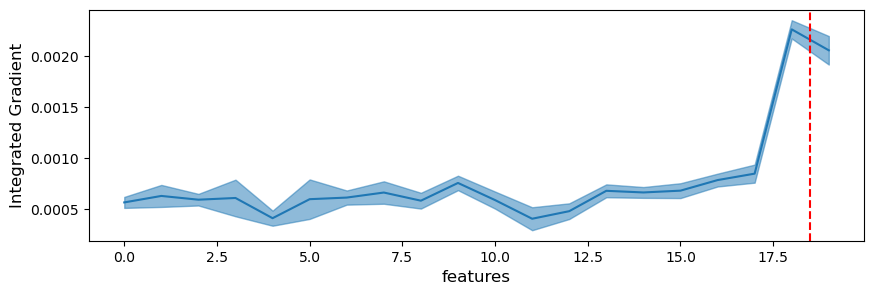

In [82]:
#%matplotlib inline
fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(10, 3))

axes.plot(attr_all_mean)
axes.fill_between(np.arange(len(attr_all_mean)),
                 attr_all_mean - attr_all_std,
                 attr_all_mean + attr_all_std, color = 'C0', alpha = 0.5)
axes.axvline(18.5,linestyle='--', color='red')
axes.set_xlabel("features", fontsize = 12)
axes.set_ylabel("Integrated Gradient", fontsize = 12)
plt.show()

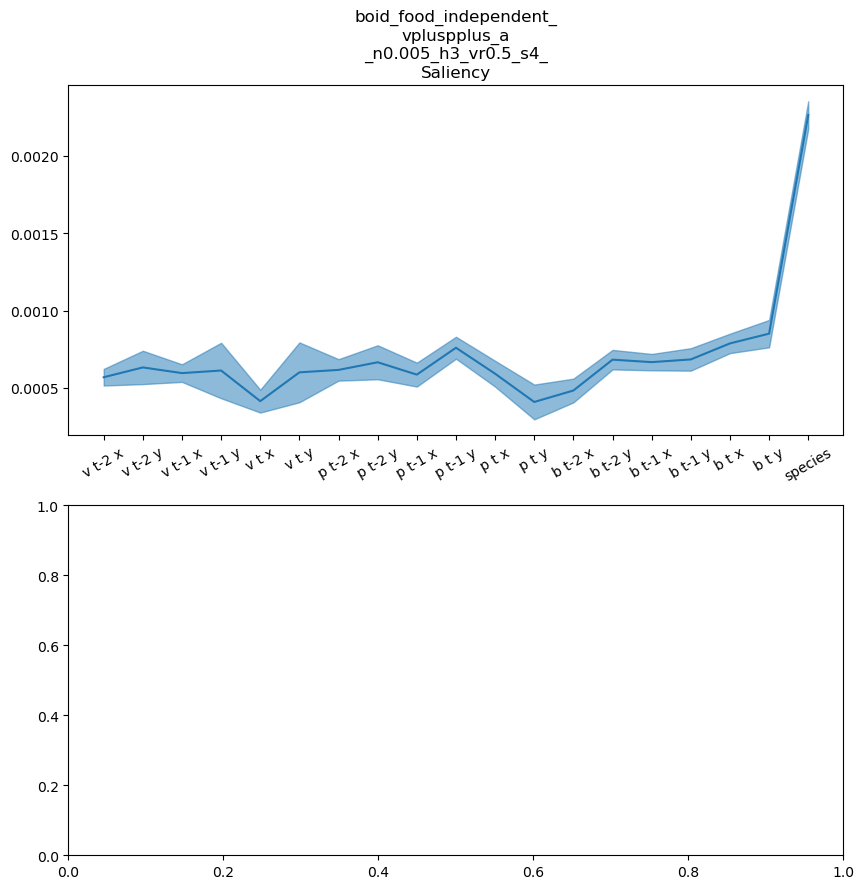

In [83]:
#%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=1,
                         figsize=(10, 10))

mean = attr_all_mean[feature_inds1]
sd = attr_all_std[feature_inds1]
axes[0].plot(mean)
axes[0].fill_between(np.arange(len(mean)),
                 mean - sd,
                 mean + sd, color = 'C0', alpha = 0.5)
axes[0].set_xticks(feature_inds1)
axes[0].set_xticklabels(feature_labels1, rotation = 30)

if len(feature_inds2) > 0:
    mean = attr_all_mean[feature_inds2]
    sd = attr_all_std[feature_inds2]
    axes[1].plot(feature_inds2,mean)
    axes[1].fill_between(feature_inds2,
                     mean - sd,
                     mean + sd, color = 'C0', alpha = 0.5)
    axes[1].set_xticks(feature_inds2)
    axes[1].set_xticklabels(feature_labels2, rotation = 50)
    
if attr == 1:
    attr_name = "IntegratedGrad"
else:
    attr_name = "Saliency"
    
title = f"{data_name}_\n{model_name}\n_n{n}_h{h}_vr{vr}_s{s}_\n{attr_name}"
axes[0].set_title(title)
plt.show()

# End here